In [1]:
import pandas as pd
import numpy as np
import os
import json

import seaborn as sns
import matplotlib.pyplot as plt

Data from [Kaggle](https://www.kaggle.com/datasnaek/youtube-new)


Tableau solution [here](https://public.tableau.com/views/youtubetrends/Story1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link)

## Reading the data

In [2]:
path = './videos/'
videos = pd.DataFrame()
for file in os.listdir(path=path):
    try:
        video = pd.read_csv(path+file, encoding='utf-8')
        video['country'] = file[:2]
        videos = pd.concat([videos, video]) 
    except: 
        video = pd.read_csv(path+file,encoding='latin-1')
        video['country']=file[:2]
        videos = pd.concat([videos, video]) 
videos.shape

(375942, 17)

In [3]:
path = 'cats/'
categories=pd.DataFrame()
for file in os.listdir(path=path):
    with open(path+file) as f:
        data = pd.DataFrame(json.load(f)['items'])
        id = pd.Series(data['id'],dtype=int)
        assignable = data['snippet'].apply(lambda x: x['assignable'])
        title = data['snippet'].apply(lambda x: x['title'])

        category = pd.concat([id,assignable,title],axis=1)
        category.columns = ['category_id', 'assignable', 'snippet']
        category['country'] = file[:2]

        categories = pd.concat([categories, category])

## Merging and writing to csv

In [9]:
df = videos.merge(categories,on=['category_id','country'])

In [6]:
df.to_csv('youtube_trends.csv')

In [10]:
#df = pd.read_csv('youtube_trends.csv')
#df.head(2)

## Questions 1

### Connection between the country and popuar categories. Is it true that in India and in Germany people like the same things, while Japanese are very different? 

In [11]:
#just a check on Japan
df.loc[df['country'] == 'JP']['snippet'].value_counts().head()

Entertainment      6259
People & Blogs     3915
Sports             2037
News & Politics    1392
Music              1290
Name: snippet, dtype: int64

In [12]:
#grouping the data by country and category, then pivoting
#how many videos of a category is in trends for specific country

cat = df.groupby(['country', 'snippet'], as_index = False).video_id.count()
cat = cat.loc[cat['video_id'] > 100]
cat_piv = cat.pivot(columns = 'country', index = 'snippet', values='video_id')\
.sort_values(by = 'CA', ascending = False)

In [13]:
cat_piv.head(2)

country,CA,DE,FR,GB,IN,JP,KR,MX,RU,US
snippet,,,,,,,,,,
Entertainment,13451.0,15292.0,9819.0,9124.0,16712.0,6259.0,8955.0,13487.0,5943.0,9964.0
News & Politics,4159.0,2935.0,3752.0,1225.0,5241.0,1392.0,7582.0,3113.0,5402.0,2487.0


In [14]:
#using rank  instead of values 
ranks = cat_piv.rank(axis = 0, ascending = False)
ranks.head(2)

country,CA,DE,FR,GB,IN,JP,KR,MX,RU,US
snippet,,,,,,,,,,
Entertainment,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0
News & Politics,2.0,3.0,6.0,9.0,2.0,4.0,2.0,5.0,3.0,6.0


<AxesSubplot:title={'center':'Rank of categories in countries by number of trending videos'}, xlabel='country', ylabel='snippet'>

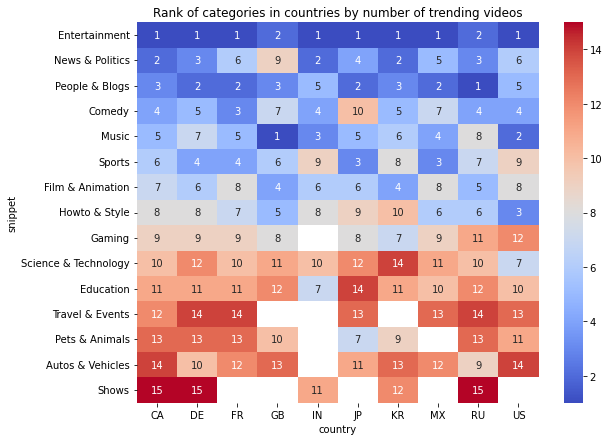

In [15]:
plt.figure(figsize=(9,7))
plt.title('Rank of categories in countries by number of trending videos')
sns.heatmap(ranks, annot = True, cmap= 'coolwarm')

### Answer 1
Entertainment is the top category in all countries but UK and russia. Germans and Indians do not watch the same, since people and blogs are only 5th in India and 2nd in Germany. Japanese don't like comedy and British people don't like News and Politics but like music the most. 

There is also another solution, ranking the categoris but views instead of number of video in trends. I've done it in Tableau. The link to the complete workbook [here](https://public.tableau.com/views/youtubetrends/Story1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link)

From the views percpective, the first 2 places are the same in all countries - Music and Entertainment. India and Germany are not very similar, GB and US have much more similarities with India.

## Questions 2

### 2. ratio of views/likes/dislikes for different categories/countries. </br> 2.1. Is it true that Mexicans like everything while British are dissatisfied with most of the things.  </br> 2.2. Is it true that musicians collect likes more easily than politicians.

I first did it in Tableau. Check out the [interactive graph](https://public.tableau.com/views/youtubetrends/Story1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link)  =) 

#### 2.1. Answer 

Mexicans and British give likes just as much as most other countires, it's russians who are mostly dissatisfied with videos, but they also put the most reactions (reactions/views ratio). Korean people are those who have the smallest likes to dislikes ration.

#### Answer 2.2. 

As for the category, it's true that music videos receive more likes than news/politics. But look at the pets and nonprofit/activism videos. The last one is the most controvertial. It get the most likes/views but also the most dislikes

In [16]:
# I'll make the smaller version in pandas to combine both country and category using only one of this metrics. 
# Say, average likes to views percentage. 
#This is not the same as we did tableau since there we summed likes and views first and then divided 
# and here we first take the ration for each video and then group it by average
df['Likes/Views %'] = (df['likes'] / df['views']) * 100
groups = df.groupby(['snippet', 'country'], as_index = False)['Likes/Views %'].mean()
gr_privot = groups.pivot(columns = 'country', index = 'snippet', values='Likes/Views %')\
.sort_values(by = 'CA', ascending = False)
gr_privot

#this is hard to read =(

country,CA,DE,FR,GB,IN,JP,KR,MX,RU,US
snippet,,,,,,,,,,
Comedy,5.195658,4.562650,6.599265,3.641234,5.428768,1.961062,1.681275,7.273504,6.224792,4.388359
Howto & Style,5.032804,5.277068,6.779337,4.361577,1.490948,2.339122,2.546121,8.431634,6.468345,4.499323
Gaming,4.949788,5.947543,6.994672,3.302404,3.688417,1.837545,2.182750,6.365975,7.285738,3.730005
Music,4.856156,6.147391,6.171435,3.829992,2.605113,5.784096,5.572232,6.881832,6.114568,4.756527
Pets & Animals,4.630205,6.591592,7.985689,3.195905,5.392569,3.253009,2.865309,4.482718,7.789795,3.347130
Education,4.402873,6.036994,7.352276,3.860426,5.333805,2.302812,2.522225,6.557936,6.075845,3.775996
Science & Technology,4.110417,5.019577,7.133763,2.708050,7.813465,1.554734,2.032471,5.167598,7.455148,3.061160
Travel & Events,3.298804,5.798109,5.887884,4.260302,1.631655,1.303055,0.904629,7.045402,6.075097,2.080807
Autos & Vehicles,3.229439,4.074820,4.301178,1.862653,2.139773,1.423278,3.118860,6.156492,5.734584,1.690350


<AxesSubplot:title={'center':'Liked categories in countries'}, xlabel='country', ylabel='snippet'>

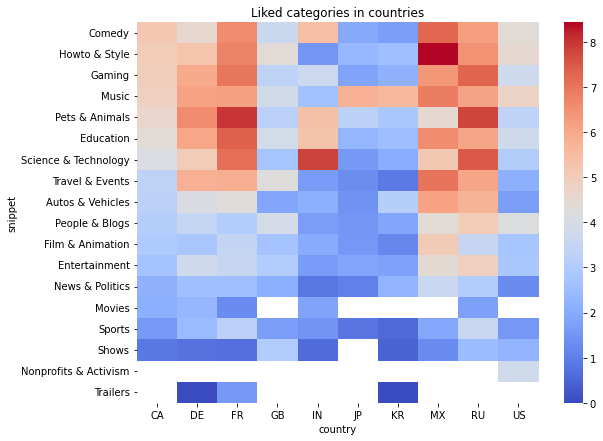

In [62]:
plt.figure(figsize=(9,7))
plt.title('Liked categories in countries')
sns.heatmap(gr_privot, cmap= 'coolwarm')

#here we can see that Mexicans and maybe France and Russia give the most likes to views. Indians really like science
#In Britain, Japan and Korea they generaly give less likes

In [17]:
# I'd rather do is look at country and category separatly

contry_likes = df.groupby(['country'])[['likes', 'views', 'dislikes']].sum()
contry_likes['like_ratio'] = (contry_likes['likes']/contry_likes['views'])*100
contry_likes['dislike_ratio'] = (contry_likes['dislikes']/contry_likes['views'])*100
contry_likes.drop(['likes', 'views', 'dislikes'], axis = 1).sort_values(by = 'like_ratio', ascending=False)


,like_ratio,dislike_ratio
country,,
RU,5.110903,0.549124
MX,4.629048,0.215377
FR,4.120298,0.187528
DE,3.588974,0.216665
CA,3.437499,0.170625
US,3.145848,0.157210
JP,3.076084,0.139974
KR,2.869490,0.126855
IN,2.553698,0.157017


#### and that's how we know that russians give the most likes but also the most dislikes

In [20]:
#the same by category
cat_likes = df.groupby(['snippet'])[['likes', 'views', 'dislikes']].sum()
cat_likes['like_ratio'] = (cat_likes['likes']/cat_likes['views'])*100
cat_likes['dislike_ratio'] = (cat_likes['dislikes']/cat_likes['views'])*100
cat_likes2 = cat_likes.drop(['likes', 'views', 'dislikes'], axis = 1)
cat_likes2.sort_values(by = 'like_ratio', ascending=False)

,like_ratio,dislike_ratio
snippet,,
Nonprofits & Activism,8.769696,1.959485
Comedy,4.904082,0.184566
Education,4.295644,0.135678
Gaming,3.859114,0.252685
Howto & Style,3.554776,0.130559
People & Blogs,2.934493,0.239971
Music,2.823487,0.115116
Pets & Animals,2.818134,0.074871
Science & Technology,2.746914,0.132887


###### nonprofit and activism is the most liked and disliked at the same time =) 
###### Comedy is probably the easiest to get likes

## Questions 3
### Сhannels that are popular in most countries
Again, we need to define what is popular. I would say number of views + number of countiries the channel appears in trends. Since we are interested in 'most' let's say 8 out of 10 is enough

Again, there is a neat solution in [Tableau](https://public.tableau.com/views/youtubetrends/Story1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link)

In [94]:
channels = df.groupby(['channel_title']).agg({'country': 'nunique',
                                             'views': 'sum'}).sort_values(by = 'views', ascending= False)

channels.head()

,country,views
channel_title,,
ChildishGambinoVEVO,9,11016766510
Marvel Entertainment,10,10430605449
NickyJamTV,7,9479859505
Ozuna,6,8623329509
ibighit,9,8205572221


In [99]:
#and there are the channels popular in at least 8 countries with the most views
popular = channels.loc[channels['country']>=8]
popular.head(10)

,country,views
channel_title,,
ChildishGambinoVEVO,9,11016766510
Marvel Entertainment,10,10430605449
ibighit,9,8205572221
DrakeVEVO,9,7637228580
ArianaGrandeVevo,9,6202230488
jypentertainment,9,5802822913
Ed Sheeran,10,5775405574
YouTube Spotlight,9,5631362655
TaylorSwiftVEVO,10,5606408128


In [ ]:
#another option - to look at number of videos

In [108]:
channels = df.groupby(['channel_title']).agg({'country': 'nunique',
                                             'views': 'sum',
                                             'video_id': 'count'})\
                                        .sort_values(by = 'video_id', ascending= False)

channels.head()

,country,views,video_id
channel_title,,,
The Late Show with Stephen Colbert,9,1036926296,984
WWE,8,1853182609,804
Late Night with Seth Meyers,8,939551124,773
VikatanTV,4,476473728,763
TheEllenShow,10,1253139659,743


In [105]:
popular = channels.loc[channels['country']>=8]
popular.head(10)
#but I think the previous one is more telling

,country,views,video_id
channel_title,,,
The Late Show with Stephen Colbert,9,1036926296,984
WWE,8,1853182609,804
Late Night with Seth Meyers,8,939551124,773
TheEllenShow,10,1253139659,743
Jimmy Kimmel Live,10,1257747286,707
The Tonight Show Starring Jimmy Fallon,10,1209134302,705
PewDiePie,10,2922023707,652
The Late Late Show with James Corden,10,1242624852,583
CNN,9,548233681,577
